In [279]:
%matplotlib inline

import sys
import os
sys.path.append("../../..")

import numpy as np
import re
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import exposure, img_as_float, morphology, color
from skimage.measure import label
from sklearn.model_selection import KFold
from PIL import Image
import xml.etree.ElementTree as ET

from osgeo import gdal
import osr
import my_packages.My_Geoprocess as mgp

from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score

import plotly
import plotly.graph_objs as go

plotly.offline.init_notebook_mode(connected=True)

## Get Rasters Informations, size, Geotransform... following one of the grid

In [280]:
ClassifFolder = '../../../Poe/Resultats/Classifications/'
ImagesFolder = '../../../Poe/Images/Acolyte/S2A_MSIL1C_20180305T230901_N0206_R101_T58KEB_20180306T00234_bisAco/S2A_MSI_2018_03_05_23_09_01_T58KEB_L2R_tif/'
raster_wavelength = ['560']
raster_Name = ['rhos_' + l + '.tif' for l in raster_wavelength]

src_ds = gdal.Open(ImagesFolder+raster_Name[0], gdal.GA_ReadOnly)
band = src_ds.GetRasterBand(1)
GT_ds = src_ds.GetGeoTransform()
proj = src_ds.GetProjection()
RasterHeight, RasterWidth = (src_ds.RasterYSize, src_ds.RasterXSize)
print(RasterHeight, RasterWidth)

10980 10980


## Define Rasters footprint

In [281]:
# Define Raster Footprint
min_x = GT_ds[0]
min_y = GT_ds[3] + RasterWidth*GT_ds[4] + RasterHeight*GT_ds[5] 
max_x = GT_ds[0] + RasterWidth*GT_ds[1] + RasterHeight*GT_ds[2]
max_y = GT_ds[3]   

srs_ds = osr.SpatialReference()
srs_ds.ImportFromWkt(src_ds.GetProjection())

srsLatLong = srs_ds.CloneGeogCS()
ct_ds = osr.CoordinateTransformation(srs_ds,srsLatLong)

min_E, min_N = ct_ds.TransformPoint(min_x, min_y)[:2]
max_E, max_N = ct_ds.TransformPoint(max_x, max_y)[:2]

print('Upper left corner : ', (min_E, min_N), '\nLower right corner : ', (max_E, max_N))


Upper left corner :  (164.99980652185837, -21.791778063706154) 
Lower right corner :  (166.0548316017674, -20.79645641405817)


## Get surveyfiles (ascii), having measurement contained in rasters footprint

In [282]:
FileWorkableSur = '../../Terrain/MesuresBathy/Poe_22and23_05_2018.txt'

MeasurementFrame = pd.read_csv(FileWorkableSur)
Lon = MeasurementFrame['Lon'].astype('float64').values
Lat = MeasurementFrame['Lat'].astype('float64').values

CoordinatesSet = np.stack([Lon,Lat], axis=1)
depth = MeasurementFrame['Depth'].astype('float32').values

del MeasurementFrame, Lon, Lat

##  Convert measurements coordinate in pixels coordinate (+ checking process)

In [283]:
testLocation = np.array([[166.0618842, -21.7883184],
                         [166.0618359, -21.7882778],
                         [166.0619313, -21.7882778],
                         [166.0619313, -21.7883652],
                         [166.0618326, -21.7883166]])

# Define pixel location of measured data
ctInv = osr.CoordinateTransformation(srsLatLong, srs_ds)
inv_geometrix = gdal.InvGeoTransform(GT_ds)
(Cols, Rows) = mgp.GetPixel(ctInv, inv_geometrix, testLocation,integer=False)
Location = ['Center', 'UpperLeft', 'UpperRight', 'LowerRight','PreviousNext']
[print(Loc,'at Row:', row,', Col:', col) for Loc, col, row in zip(Location, Cols,Rows)]

# Project coordinates in pixel coordinates then filter measured data projected outside image extent
px, py = mgp.GetPixel(ctInv, inv_geometrix, CoordinatesSet,integer=False) # Case for dense field data, need interger=False for wheigtering or interpolation
indexOut = np.logical_or(np.logical_or(py>RasterHeight-1,py<0), np.logical_or(px>RasterWidth-1,px<0))
px, py = px[~indexOut], py[~indexOut]

# Adjust water depth following the Tide at the image sensor Time
TideHeight = 1.31 # Height of tide from SHOM website
depth = depth[~indexOut]+TideHeight

# filter measured data with negative depth (due to tide)
indexOut = depth<0
print('Number of point with negative depth :', np.sum(indexOut))
px, py, depth = px[~indexOut], py[~indexOut], depth[~indexOut]
assert px.shape==py.shape and px.shape == depth.shape

no int
Center at Row: 10979.4685216 , Col: 10979.5091234
UpperLeft at Row: 10979.0156563 , Col: 10979.0128596
UpperRight at Row: 10979.0224421 , Col: 10979.999165
LowerRight at Row: 10979.9899339 , Col: 10979.9925083
PreviousNext at Row: 10979.444926 , Col: 10978.9757872
no int
Number of point with negative depth : 0


## Get workingIndex or Index of classification and bathymetry mapping
###### In others words :        ClassifIndex = ~Soil x ~DeepOcean x CroppedImage
######                                     ClassifIndex.shape == Initial_Rasters.shape

(10980, 10980)


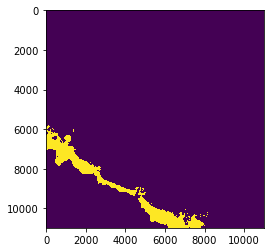

In [284]:
Lagoon = 'Mask/Lagoon.tif'

ClassifIndex = gdal.Open(ImagesFolder + Lagoon, gdal.GA_ReadOnly)
ClassifIndex = ClassifIndex.GetRasterBand(1).ReadAsArray().astype(bool)
print(ClassifIndex.shape)
plt.imshow(ClassifIndex)

## Create index(SurveyIndex) indicating the presence of measurements in a pixel
## Create dictionary(Dicto) of depths measured at a pixel location

In [285]:
# Create sub (2d) index for measured pixel
SurveyIndex = np.full(ClassifIndex.shape, 0, dtype=np.int8)
DictoDeph = {}
DictoPos = {}
for i in range(len(px)):
    Intpy, Intpx = int(py[i]),int(px[i])
    try:
        if ClassifIndex[Intpy, Intpx] == False: # Case for Poe int(px)
            continue
        SurveyIndex[Intpy, Intpx] += 1
        if SurveyIndex[Intpy, Intpx] == 1:
            DictoDeph[Intpy, Intpx] = []
            DictoPos[Intpy, Intpx] = []
            DictoDeph[Intpy, Intpx].append(depth[i])
            DictoPos[Intpy, Intpx].append([py[i], px[i]])
        else:
            DictoDeph[Intpy, Intpx].append(depth[i])
            DictoPos[Intpy, Intpx].append([py[i], px[i]])
    except:
        print(i)

## Compute Statistics on pixels containing measurements 

In [286]:
SurveyRatio = np.full(ClassifIndex.shape, np.NaN, dtype= np.float_)
SurveyDisposition = {}
for i, j  in DictoDeph.keys():
    assert len(DictoPos[(i, j)]) == len(DictoDeph[(i, j)])
    Points = np.asarray(DictoPos[(i, j)])
    SurveyRatio[i, j], SurveyDisposition[i, j] = mgp.get_OccupiedRatio(Points[:,0], Points[:,1], radius=0.1)


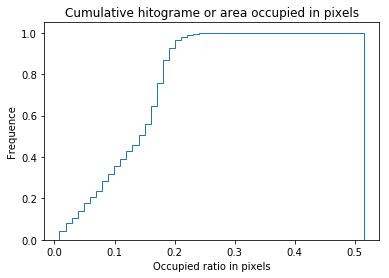

In [287]:
n, bins, patches = plt.hist(SurveyRatio[~np.isnan(SurveyRatio)], 50, histtype='step', cumulative=1, normed=True)
plt.xlabel('Occupied ratio in pixels')
plt.ylabel('Frequence')
plt.title('Cumulative hitograme or area occupied in pixels')


In [288]:
CoverThreshold = 0.18
print('Nombre de Pixels Totale : {0:d}\nNombre de Pixels conservé: {1:d}'.format(np.sum(~np.isnan(SurveyRatio)),np.sum(SurveyRatio>CoverThreshold))) 

Nombre de Pixels Totale : 2417
Nombre de Pixels conservé: 607


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning:

invalid value encountered in greater



In [289]:
SurveyValues = np.full(ClassifIndex.shape, np.NaN, dtype= np.float_)
SurveyIndex = np.full(ClassifIndex.shape, False, dtype=np.bool_)
PixMethod = ['nearest', 'linear']
PixMethodIndex = 1

rows, cols = np.where(SurveyRatio>CoverThreshold)
for i, j  in zip(rows,cols):
    Points = np.asarray(DictoPos[(i, j)])
    SurveyValues[i, j] = mgp.InterpPixDepth(Points, 
                                            DictoDeph[i, j], 
                                            modes=[PixMethod[PixMethodIndex]], 
                                            PlotArg=False)[0]
    SurveyIndex[i, j] = True

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning:

invalid value encountered in greater



## Load Optical Data
### WARNING: Poe special case -> to avoid bigger backup size, data need to be resize at Rasters dimension

In [290]:
npzfile = np.load('../../../Poe/CompressedData/XData.npz')
Xc = npzfile['VolumFreeR'][:,:,0:5] # croped shape without NIR Band
ErMap = npzfile['ErMap'][:,:,0:5] # croped shape without NIR Band
BandName = ['ShortBlue', 'Blue', 'Green', 'Red', 'LargeRed']

X = np.full((RasterHeight, RasterWidth, len(BandName)), np.nan)
ValidMap = np.full((RasterHeight, RasterWidth), False)

ErMap = ErMap.sum(axis=2)==0
ValidMap[5000:,0:8500] = ErMap[:,:]
X[5000:,0:8500] = Xc[:,:]

del Xc, ErMap

ToclassifyIndex = np.logical_and(ValidMap,ClassifIndex)
X[ToclassifyIndex,:] = np.log(5000*X[ToclassifyIndex,:])
X[~ToclassifyIndex,:] = np.nan
X.shape

(10980, 10980, 5)

## Special case in Poe, Area of interest for specific calibration manually created

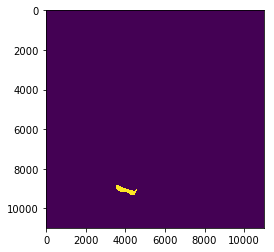

In [291]:
ShapeFolder = '../../../Poe/Shapes/'
RoiPathName = ['SheratonLagoon.shp', 'SheratonLagoonWithPass.shp']
Roidescription = ['Lagon de Poe situe face au sheraton, camping sauvage et auberge de jeunesse. Points internes au lagon uniquement. Aucun points situé dans la faille ou en zone extérieur de plus forte profondeurs', 
                  'Fail et Lagon de Poe situe face au sheraton, camping sauvage et auberge de jeunesse. Les points situés dans la faille sont effectué dans une haut de profondeur bien plus elevée et irregulière. Ils ont étaient realises avec une plus forte variation d''angle de vue du sondeur, due a la houle et dans une haut avec de forts courrant certainement bien plus chargé en composants']
CalibZoIndex = 0

ResctictedLagoon = mgp.create_mask_from_vector(ShapeFolder + RoiPathName[CalibZoIndex],  RasterHeight, RasterWidth, GT_ds, proj, target_value=1, format=gdal.GDT_Byte)
ResctictedLagoon = ResctictedLagoon.GetRasterBand(1).ReadAsArray().astype(bool)
plt.imshow(ResctictedLagoon)

## Visual check !

Nombre de pixel comportant une mesure immergées: 521


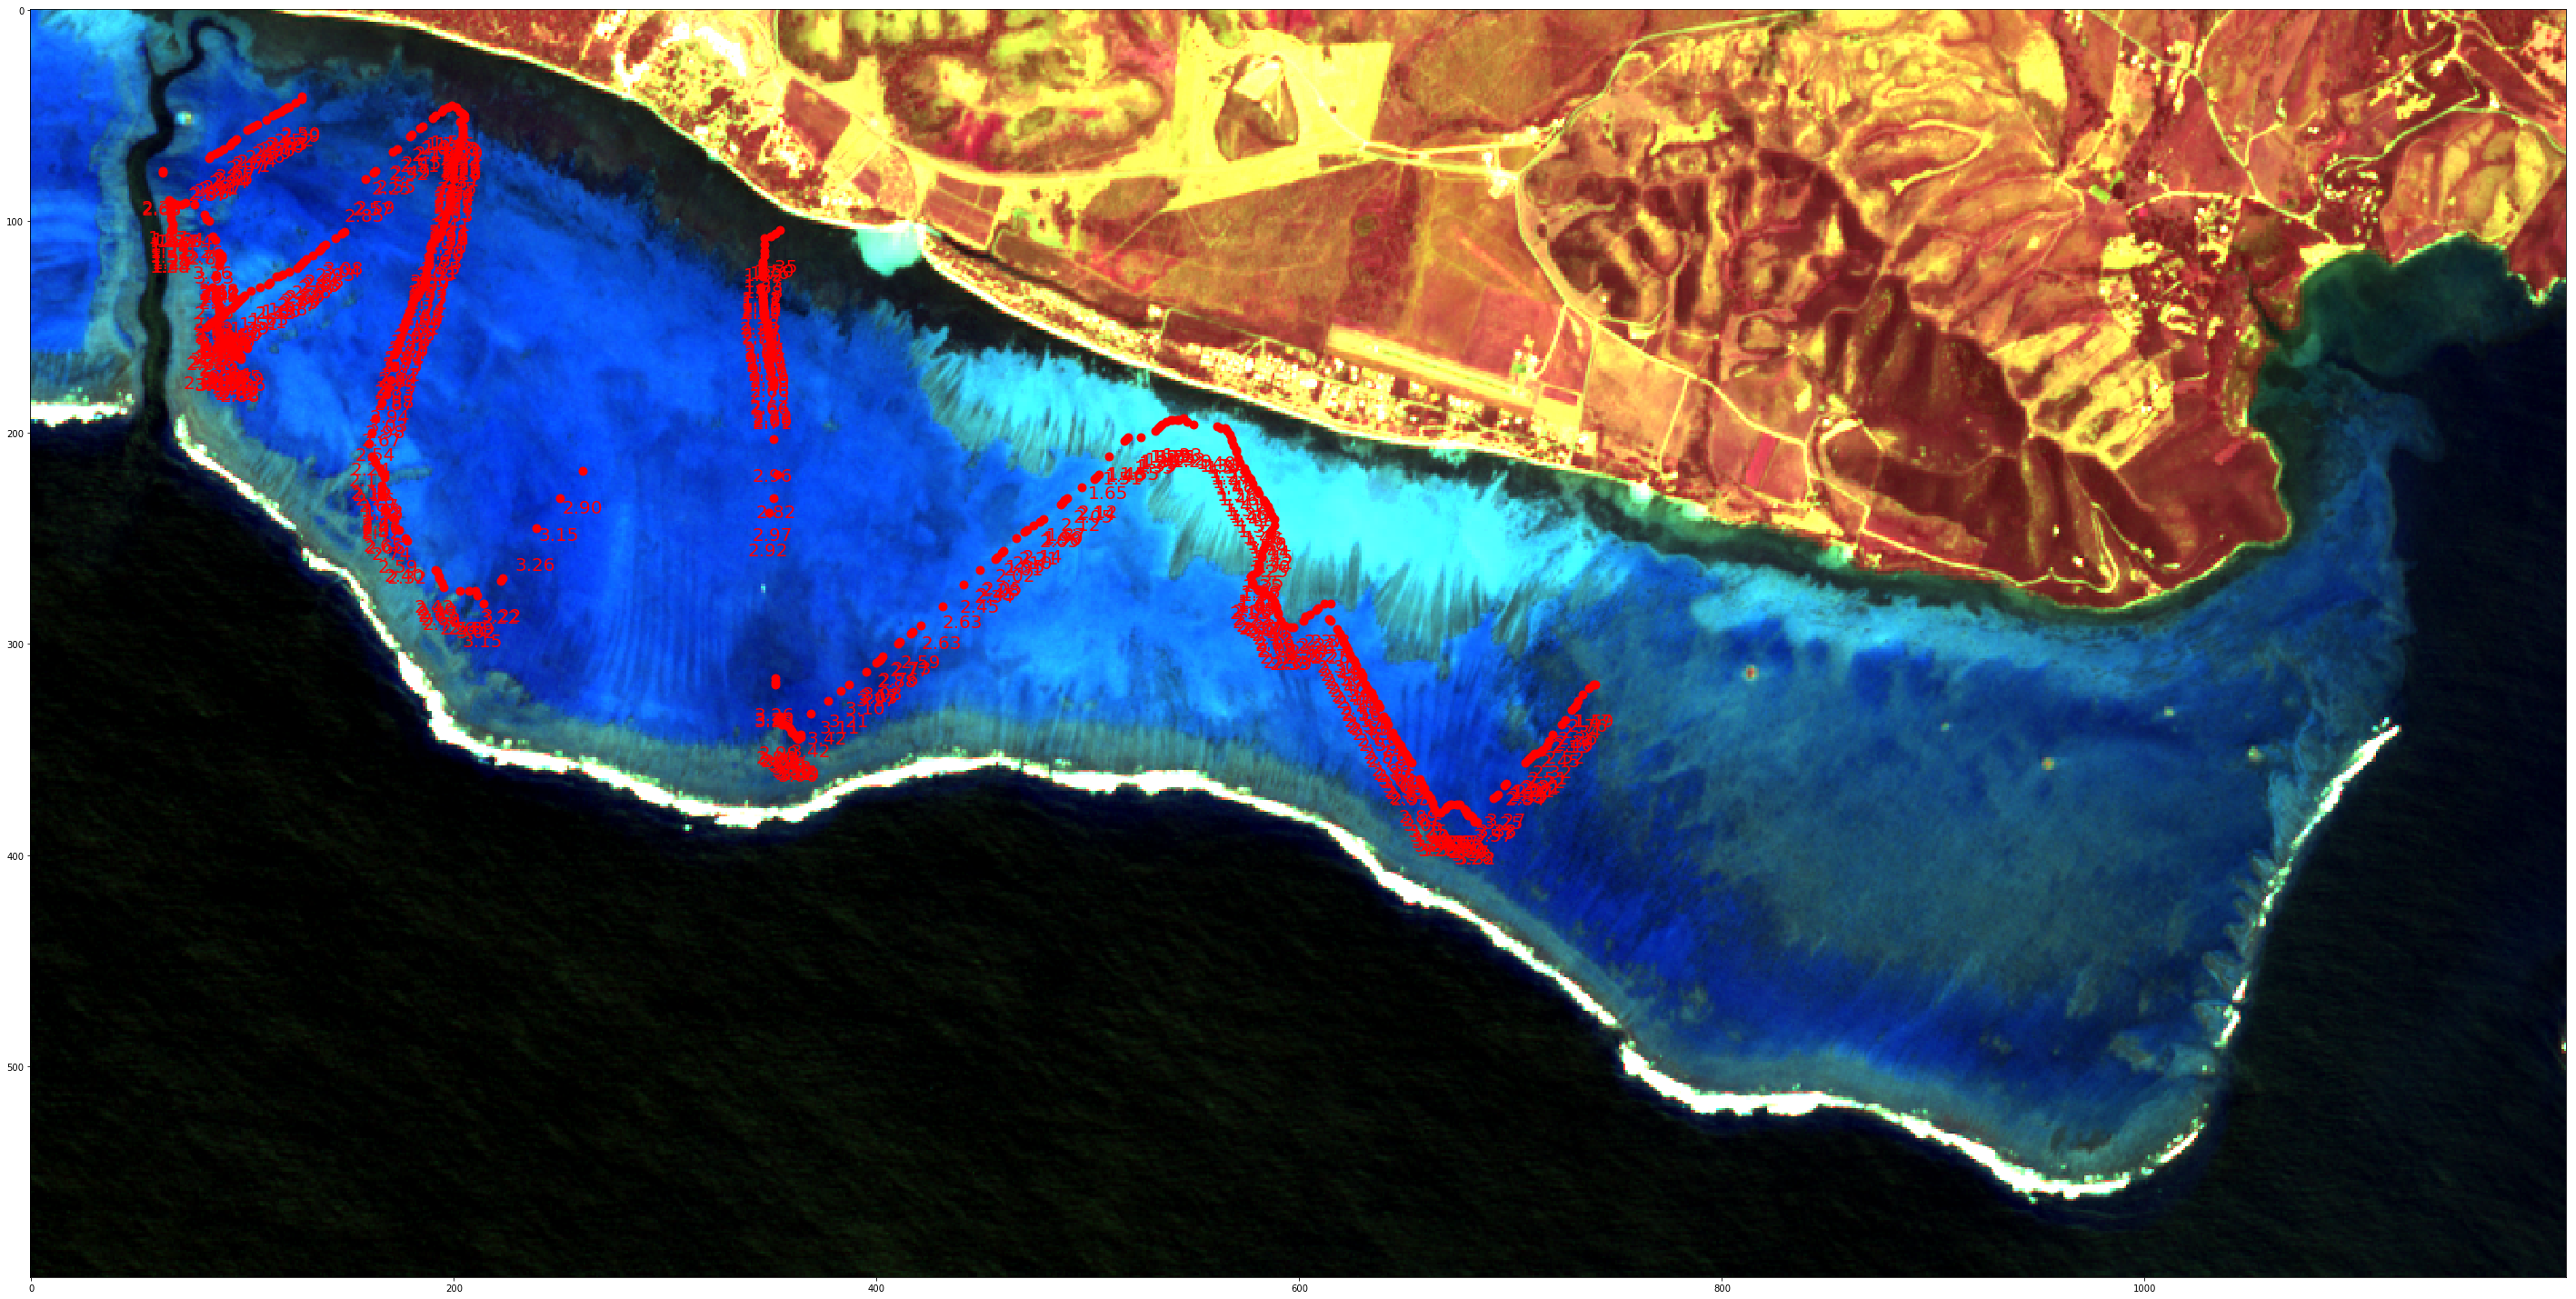

In [292]:
RGB_wavelength = ['704', '665', '560' ]
Composite_Names = ['rhos_' + l + '.tif' for l in RGB_wavelength]

RGB = [mgp.GetSparseCrop(ImagesFolder+rbgBand,(RasterHeight, RasterWidth), 3450, 8800, 1200, 600)  for rbgBand in Composite_Names]
VisRGB = np.dstack(RGB)
del RGB

# Manual cropping for better visual rendering
ScatterIndex = np.logical_and(ResctictedLagoon[8800:9400,3450:4650],SurveyIndex[8800:9400,3450:4650])
CroppedDepth = SurveyValues[8800:9400,3450:4650] # Average deph of pixels contained in the visual cropped

# Scatter coordinates and image in rendered dimension
x,y = np.where(ScatterIndex)

Im = mgp.RescalImg(VisRGB[8800:9400,3450:4650], (5,95))

# Plot
fig, ax = plt.subplots(figsize=(50,50))
plt.imshow(Im)
plt.scatter(y,x,s=80, c='r')
for i in range(len(x)):
    ax.annotate('{0:.2f}'.format(CroppedDepth[ScatterIndex][i]), (y[i]-10,x[i]+20), color='red', size=20)
print("Nombre de pixel comportant une mesure immergées:",len(x))
del VisRGB

## Creation of calibration dataset

In [293]:
assert X.shape[:2]==SurveyValues.shape
ind = ResctictedLagoon * (SurveyIndex>0) * ToclassifyIndex # Index of calibration data
Data_x = X[ind,:] # model optical descriptors
Data_y = SurveyValues[ind].reshape(np.sum(ind),) # model target depth

## release memory

In [294]:
del X

## exploratory statistics

ShortBlue correlation :  0.0867424305191
Blue correlation :  -0.00835404424434
Green correlation :  -0.170540289423
Red correlation :  -0.757825790653
LargeRed correlation :  -0.892511824535


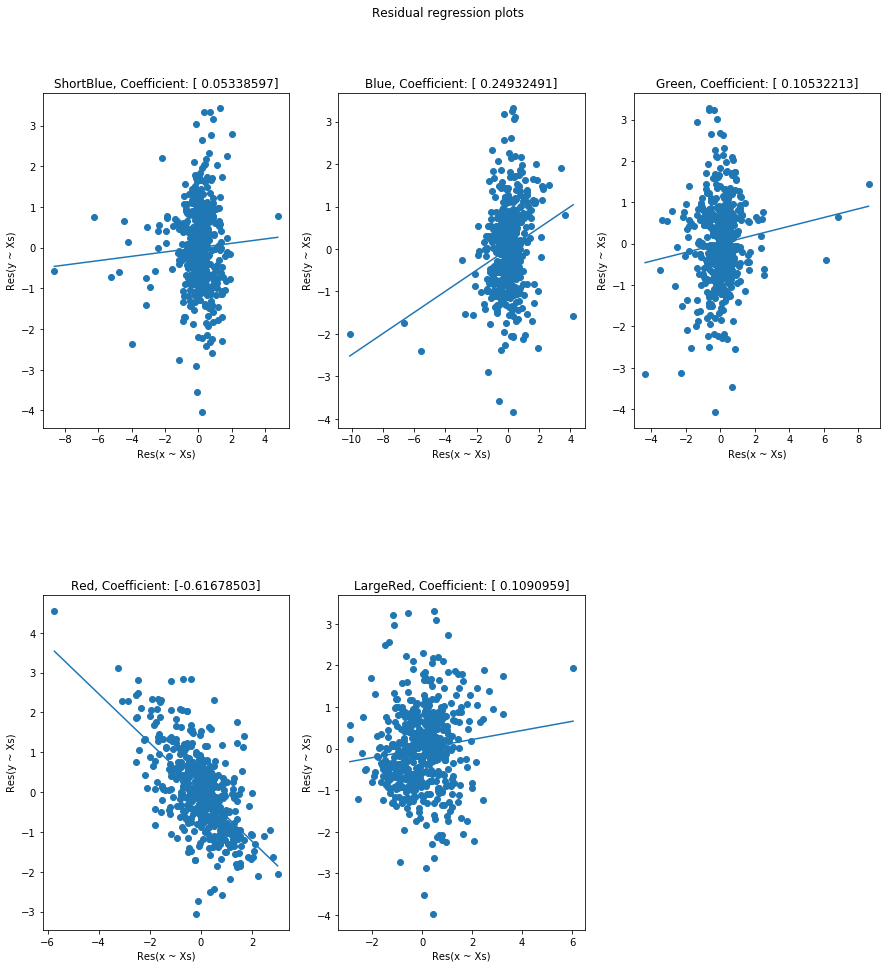

In [295]:
for i in range(Data_x.shape[1]):
    print(str(BandName[i]),'correlation : ',np.corrcoef(Data_x[:,i],Data_y)[0,1])
    print("="*10)
mgp.plot_ResRegPlots(Data_x, Data_y, Scale=True, SetTitles=True, Titles=[str(i) for i in BandName])

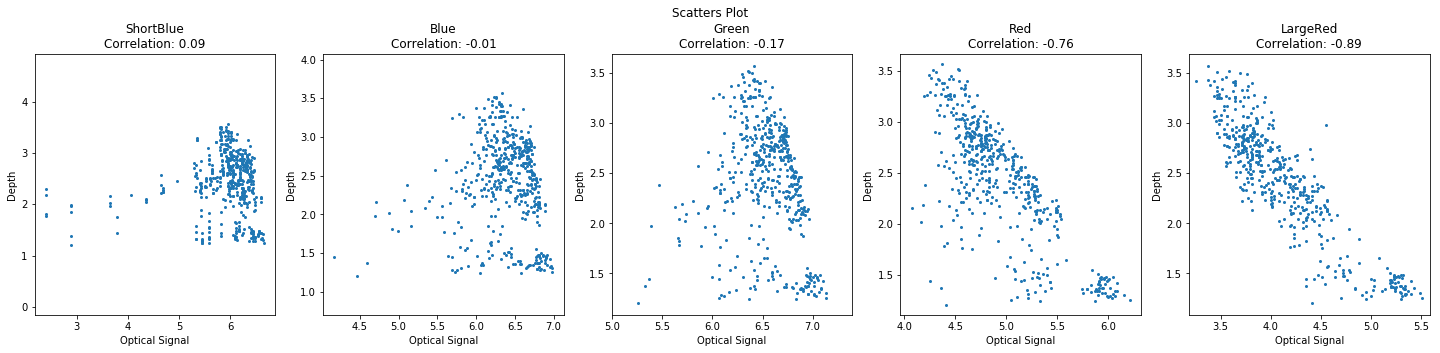

In [296]:
fig, axes = plt.subplots(1,5, figsize=(25, 5))
fig.suptitle('Scatters Plot')
fig.subplots_adjust(hspace=.5, top=.85)
for i, ax in enumerate(fig.axes):
    ax.scatter(Data_x[:,i],Data_y, s=4)
    ax.set_title(BandName[i]+'\nCorrelation: {0:0.2f}'.format(np.corrcoef(Data_x[:,i],Data_y)[0,1]))
    ax.set_ylabel('Depth')
    ax.axis('equal')
    ax.set_xlabel('Optical Signal')

In [297]:
x = Data_x
y = Data_y

# Simple linear Regression (Stumpf)

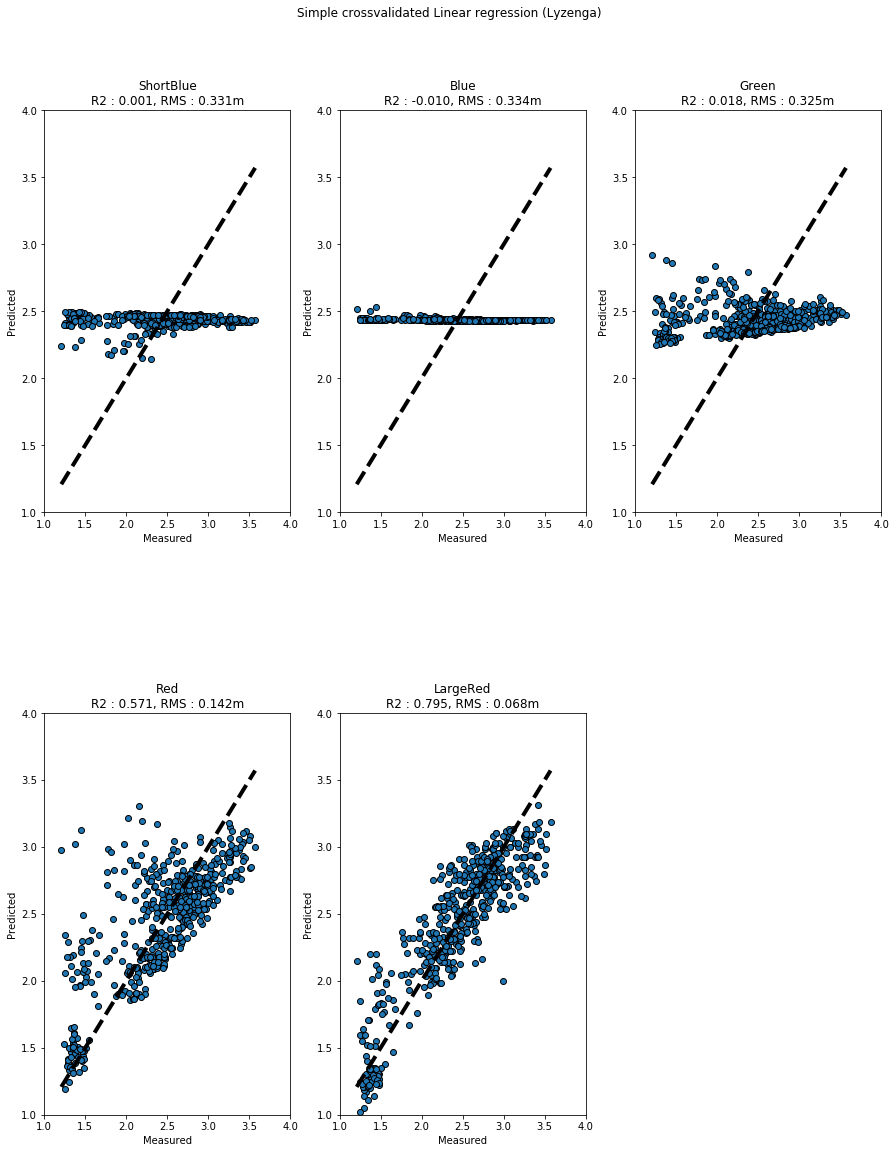

In [298]:
plotsPerRows = 3
fig , axes = plt.subplots(int(np.ceil(x.shape[1]/plotsPerRows)),plotsPerRows, figsize=(15,18))
fig.suptitle('Simple crossvalidated Linear regression (Lyzenga)')
fig.subplots_adjust(hspace=.5, top=.9)
Outputs = []

for i, ax in enumerate(fig.axes):
    if i >= x.shape[1]:
        ax.set_visible(False)
        continue
    Outputs.append(mgp.my_LeaveOneOutCV(linear_model.LinearRegression(), x[:,i].reshape(-1,1), y, ax=ax, SetTitles= True, Titles=BandName[i]))
    ax.set_xlim(1,4)
    ax.set_ylim(1,4)
plt.show()

# Simple Multi-linear Regression (Lyzenga)

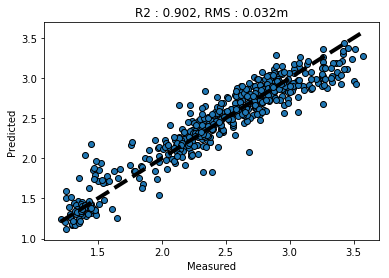

In [240]:
Outputs = []

Outputs.append(mgp.my_LeaveOneOutCV(linear_model.LinearRegression(), x, y,))


# 2 Iterations Simple Multi-linear Regression (Lyzenga)

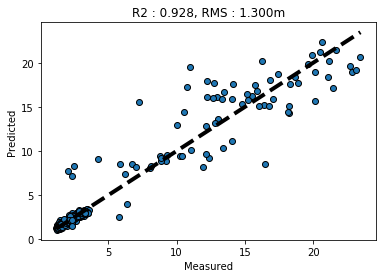

In [153]:
lr = mgp.my_2IterationsModel(linear_model.LinearRegression, [5.5, 12])
Outputs.append(mgp.my_LeaveOneOutCV(lr, x, y, DoPlot=True))

# Multi-linear : Ridge Regression

Best RMS : 0.032 with alpha = exp(-1.36)
Best R2 : 0.902 with alpha = exp(-1.36)



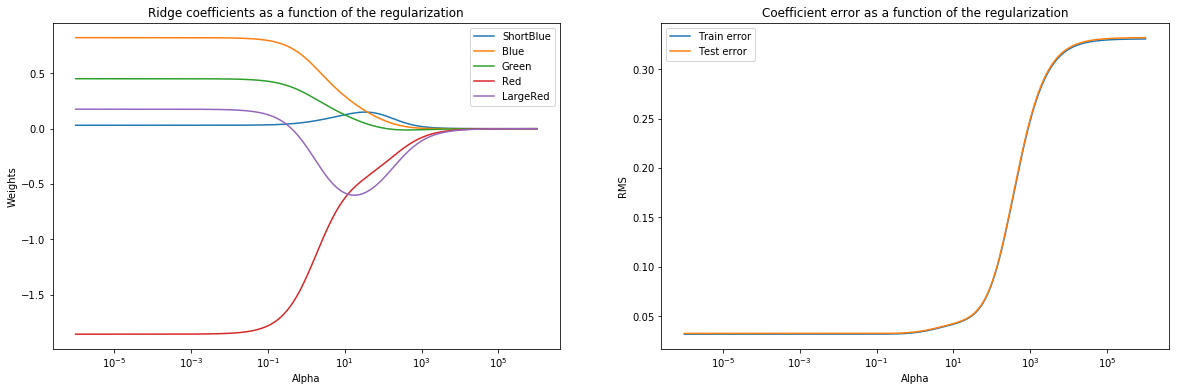

In [269]:

alphas = np.logspace(-6, 6, 200)
Outputs = []

for a in alphas:
    lr = linear_model.Ridge(alpha=a)
    Outputs.append(mgp.my_LeaveOneOutCV(lr, x, y, DoPlot=False))

coefs = [Outputs[i][1]['Coefs'] for i in range(len(alphas))]
RMS = [Outputs[i][1]['RMS'] for i in range(len(alphas))]
R2_scores = [Outputs[i][1]['R2_score'] for i in range(len(alphas))]
tr_RMS = [Outputs[i][1]['tr_RMS'] for i in range(len(alphas))]
tr_R2_scores = [Outputs[i][1]['tr_R2_score'] for i in range(len(alphas))]

# Display results
fig, ax = plt.subplots(nrows=1, ncols= 2, figsize=(20, 6))

ax[0].plot(alphas, coefs)
ax[0].set_xscale('log')
ax[0].set_xlabel('Alpha')
ax[0].set_ylabel('Weights')
ax[0].set_title('Ridge coefficients as a function of the regularization')
ax[0].axis('tight')
ax[0].legend(labels=[str(i) for i in BandName] )
ax[1].plot(alphas, tr_RMS, label='Train error')
ax[1].plot(alphas, RMS, label='Test error')
ax[1].legend()
ax[1].set_xscale('log')
ax[1].set_xlabel('Alpha')
ax[1].set_ylabel('RMS')
ax[1].set_title('Coefficient error as a function of the regularization')
ax[1].axis('tight')

fig.show

print('Best RMS : {0:.3f} with alpha = exp({1:1.2f})\nBest R2 : {2:.3f} with alpha = exp({3:1.2f})\n'.format(
np.min(RMS), np.log10(alphas[np.argmin(RMS)]), np.max(R2_scores), np.log10(alphas[np.argmax(R2_scores)])))

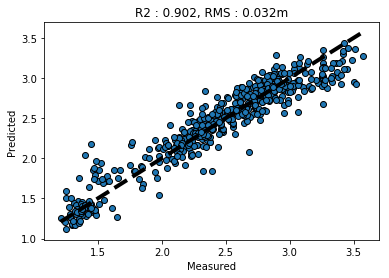

In [270]:
a = alphas[np.argmin(RMS)]
lr = linear_model.Ridge(alpha=a)
Outputs.append(mgp.my_LeaveOneOutCV(lr, x, y, DoPlot=True))

# Multi-linear : 2 Iterations Ridge Regression

Best RMS : 1.291 with alpha = exp(-1.36)
Best R2 : 0.929 with alpha = exp(-1.36)



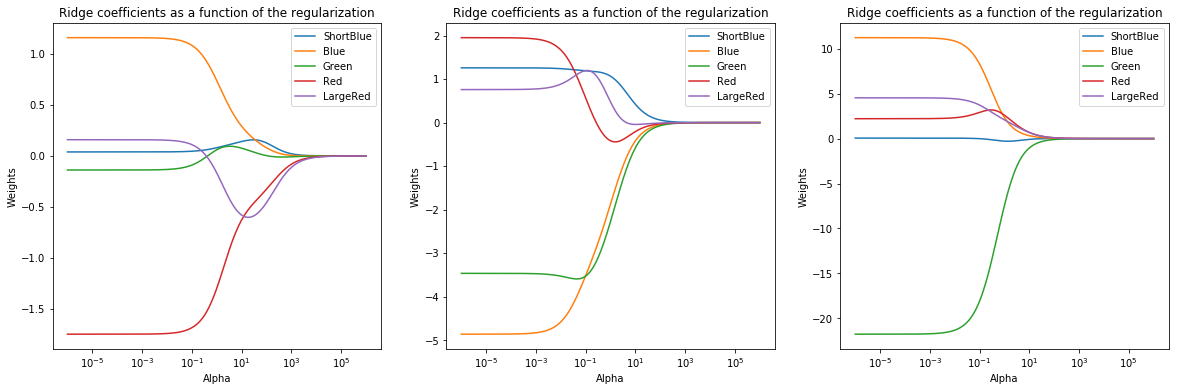

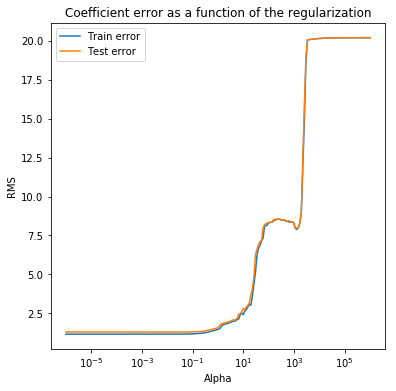

In [90]:
alphas = np.logspace(-6, 6, 200)
Outputs = []

for a in alphas:
    lr = mgp.my_2IterationsModel(linear_model.Ridge, [5.5, 12], ModelsArguments={'alpha':a})
    Outputs.append(mgp.my_LeaveOneOutCV(lr, x, y, DoPlot=False))

coefs0 = [Outputs[i][1]['Coefs'][0] for i in range(len(alphas))]
coefs1 = [Outputs[i][1]['Coefs'][1] for i in range(len(alphas))]
coefs2 = [Outputs[i][1]['Coefs'][2] for i in range(len(alphas))]
RMS = [Outputs[i][1]['RMS'] for i in range(len(alphas))]
R2_scores = [Outputs[i][1]['R2_score'] for i in range(len(alphas))]
tr_RMS = [Outputs[i][1]['tr_RMS'] for i in range(len(alphas))]
tr_R2_scores = [Outputs[i][1]['tr_R2_score'] for i in range(len(alphas))]
# Display results
fig, ax = plt.subplots(nrows=1, ncols= 3, figsize=(20, 6))

ax[0].plot(alphas, coefs0)
ax[1].plot(alphas, coefs1)
ax[2].plot(alphas, coefs2)
[ax[i].set_xscale('log') for i in range(3)]
[ax[i].set_xlabel('Alpha')for i in range(3)]
[ax[i].set_ylabel('Weights')for i in range(3)]
[ax[i].set_title('Ridge coefficients as a function of the regularization')for i in range(3)]
[ax[i].axis('tight')for i in range(3)]
[ax[i].legend(labels=[str(i) for i in BandName] )for i in range(3)]
fig.show

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(alphas, tr_RMS, label='Train error')
ax.plot(alphas, RMS, label='Test error')
ax.legend()
ax.set_xscale('log')
ax.set_xlabel('Alpha')
ax.set_ylabel('RMS')
ax.set_title('Coefficient error as a function of the regularization')
ax.axis('tight')


print('Best RMS : {0:.3f} with alpha = exp({1:1.2f})\nBest R2 : {2:.3f} with alpha = exp({3:1.2f})\n'.format(
np.min(RMS), np.log10(alphas[np.argmin(RMS)]), np.max(R2_scores), np.log10(alphas[np.argmax(R2_scores)])))

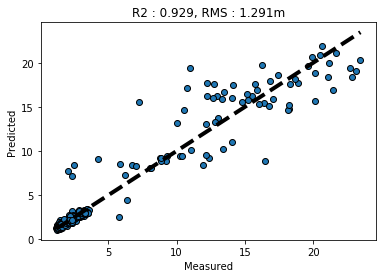

In [91]:
ModArg = {'alpha': alphas[np.argmin(RMS)]}
lr = mgp.my_2IterationsModel(linear_model.Ridge, [5.5, 12], ModelsArguments=ModArg )
Outputs.append(mgp.my_LeaveOneOutCV(lr, x, y, DoPlot=True))

# Multi-linear : Lasso Regression

Best RMS : 0.032 with alpha = exp(-6.00)
Best R2 : 0.902 with alpha = exp(-6.00)



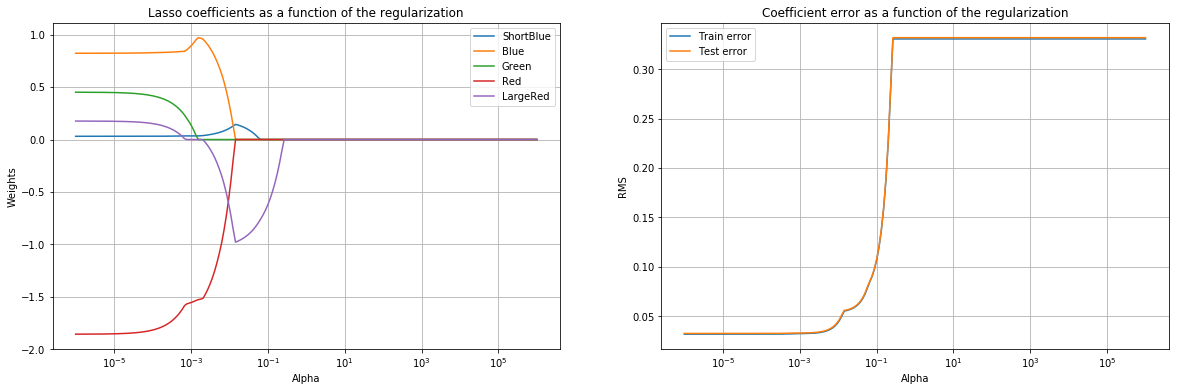

In [299]:

alphas = np.logspace(-6, 6, 200)
Outputs = []

for a in alphas:
    lr = linear_model.Lasso(alpha=a, max_iter=1000)
    Outputs.append(mgp.my_LeaveOneOutCV(lr, x, y, DoPlot=False))

coefs = [Outputs[i][1]['Coefs'] for i in range(len(alphas))]
RMS = [Outputs[i][1]['RMS'] for i in range(len(alphas))]
R2_scores = [Outputs[i][1]['R2_score'] for i in range(len(alphas))]
tr_RMS = [Outputs[i][1]['tr_RMS'] for i in range(len(alphas))]
tr_R2_scores = [Outputs[i][1]['tr_R2_score'] for i in range(len(alphas))]

# Display results
fig, ax = plt.subplots(nrows=1, ncols= 2, figsize=(20, 6))

ax[0].plot(alphas, coefs)
ax[0].set_xscale('log')
ax[0].set_xlabel('Alpha')
ax[0].set_ylabel('Weights')
ax[0].set_title('Lasso coefficients as a function of the regularization')
ax[0].axis('tight')
ax[0].legend(labels=[str(i) for i in BandName] )
ax[0].grid()
ax[1].plot(alphas, tr_RMS, label='Train error')
ax[1].plot(alphas, RMS, label='Test error')
ax[1].legend()
ax[1].set_xscale('log')
ax[1].set_xlabel('Alpha')
ax[1].set_ylabel('RMS')
ax[1].set_title('Coefficient error as a function of the regularization')
ax[1].axis('tight')
ax[1].grid()

fig.show

print('Best RMS : {0:.3f} with alpha = exp({1:1.2f})\nBest R2 : {2:.3f} with alpha = exp({3:1.2f})\n'.format(
np.min(RMS), np.log10(alphas[np.argmin(RMS)]), np.max(R2_scores), np.log10(alphas[np.argmax(R2_scores)])))

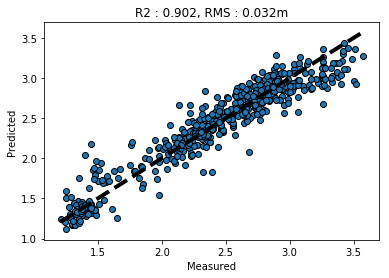

In [300]:
a = alphas[np.argmin(RMS)]
lr = linear_model.Lasso(alpha=a, max_iter=1000)
Outputs.append(mgp.my_LeaveOneOutCV(lr, x, y, DoPlot=True))

# 2 Iterations Multi-linear : Lasso Regression

Best RMS : 1.288 with alpha = exp(-2.08)
Best R2 : 0.929 with alpha = exp(-2.08)



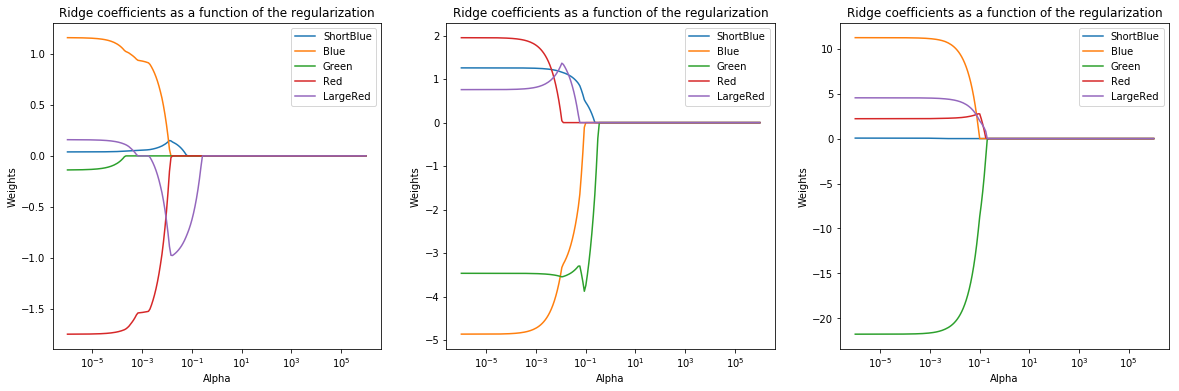

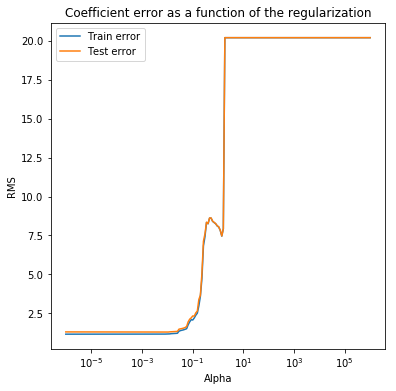

In [210]:
alphas = np.logspace(-6, 6, 200)
Outputs = []

for a in alphas:
    lr = mgp.my_2IterationsModel(linear_model.Lasso, [5.5, 12], ModelsArguments={'alpha':a, 'max_iter':1000})
    Outputs.append(mgp.my_LeaveOneOutCV(lr, x, y, DoPlot=False))

coefs0 = [Outputs[i][1]['Coefs'][0] for i in range(len(alphas))]
coefs1 = [Outputs[i][1]['Coefs'][1] for i in range(len(alphas))]
coefs2 = [Outputs[i][1]['Coefs'][2] for i in range(len(alphas))]
RMS = [Outputs[i][1]['RMS'] for i in range(len(alphas))]
R2_scores = [Outputs[i][1]['R2_score'] for i in range(len(alphas))]
tr_RMS = [Outputs[i][1]['tr_RMS'] for i in range(len(alphas))]
tr_R2_scores = [Outputs[i][1]['tr_R2_score'] for i in range(len(alphas))]
# Display results
fig, ax = plt.subplots(nrows=1, ncols= 3, figsize=(20, 6))

ax[0].plot(alphas, coefs0)
ax[1].plot(alphas, coefs1)
ax[2].plot(alphas, coefs2)
[ax[i].set_xscale('log') for i in range(3)]
[ax[i].set_xlabel('Alpha')for i in range(3)]
[ax[i].set_ylabel('Weights')for i in range(3)]
[ax[i].set_title('Ridge coefficients as a function of the regularization')for i in range(3)]
[ax[i].axis('tight')for i in range(3)]
[ax[i].legend(labels=[str(i) for i in BandName] )for i in range(3)]
fig.show

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(alphas, tr_RMS, label='Train error')
ax.plot(alphas, RMS, label='Test error')
ax.legend()
ax.set_xscale('log')
ax.set_xlabel('Alpha')
ax.set_ylabel('RMS')
ax.set_title('Coefficient error as a function of the regularization')
ax.axis('tight')


print('Best RMS : {0:.3f} with alpha = exp({1:1.2f})\nBest R2 : {2:.3f} with alpha = exp({3:1.2f})\n'.format(
np.min(RMS), np.log10(alphas[np.argmin(RMS)]), np.max(R2_scores), np.log10(alphas[np.argmax(R2_scores)])))

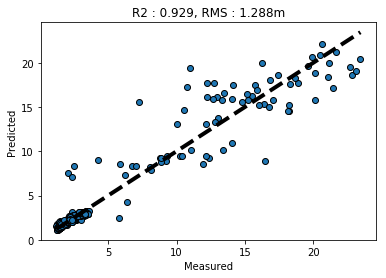

In [211]:
ModArg = {'alpha': alphas[np.argmin(RMS)], 'max_iter':1000}
lr = mgp.my_2IterationsModel(linear_model.Lasso, [5.5, 12], ModelsArguments=ModArg )
Outputs.append(mgp.my_LeaveOneOutCV(lr, x, y, DoPlot=True))

# Huber Regression

In [ ]:
SizeE, SizeA = 40, 200
epsilons = np.linspace(1.01, 1.40, SizeE)
alphas = np.logspace(-7, 5, SizeA)
RMS = np.full((SizeE,SizeA), np.nan, np.float)
R2_scores = np.full((SizeE,SizeA), np.nan, np.float)
coefs = np.full((SizeE,SizeA,x.shape[1]), np.nan, np.float)

Outputs = []

for ie, e in enumerate(epsilons):
    Outputs.append([])
    for ia, a in enumerate(alphas):
        lr = linear_model.HuberRegressor(alpha=a, epsilon=e, fit_intercept=True, max_iter=1000)
        Outputs[ie].append(mgp.my_LeaveOneOutCV(lr, x, y, DoPlot=False))
    RMS[ie,:] = np.asarray([Outputs[ie][i][1]['RMS'] for i in range(len(alphas))])
    R2_scores[ie,:] = np.asarray([Outputs[ie][i][1]['R2_score'] for i in range(len(alphas))])
    coefs[ie,:,:] = np.asarray([Outputs[ie][i][1]['Coefs'] for i in range(len(alphas))])

bestE_R2, bestA_R2 = np.where(np.max(R2_scores)==R2_scores)
bestE_RMS, bestA_RMS = np.where(np.min(RMS)==RMS)

print('Best RMS : {0:.3f} with alpha = exp({1:1.2f}), epsilons = {2:1.2f}\nBest R2 : {3:.3f} with alpha = exp({4:1.2f}), epsilons = {5:1.2f}\n'.format(
RMS[bestE_RMS, bestA_RMS][0], np.log10(alphas[bestA_RMS][0]), epsilons[bestE_RMS][0], 
R2_scores[bestE_R2, bestA_R2][0], np.log10(alphas[bestA_R2][0]), epsilons[bestE_R2][0]))

In [ ]:
# Display results
fig, ax = plt.subplots(nrows=1, ncols= 2, figsize=(20, 6))

ax[0].plot(alphas, [coefs[bestE_R2,i,:].reshape(-1,) for i in range(len(alphas))])
ax[0].set_xscale('log')
ax[0].set_xlabel('Alpha')
ax[0].set_ylabel('Weights')
ax[0].set_title('Lasso coefficients as a function of the regularization')
ax[0].axis('tight')
ax[0].legend(labels=[str(i) for i in BandName] )
ax[0].grid()
ax[1].plot(alphas, RMS[bestE_R2,:].T)
ax[1].set_xscale('log')
ax[1].set_xlabel('Alpha')
ax[1].set_ylabel('RMS')
ax[1].set_title('Coefficient error as a function of the regularization')
ax[1].axis('tight')
ax[1].grid()

fig.show

In [ ]:
lr = linear_model.HuberRegressor(alpha=alphas[bestA_R2], epsilon=epsilons[bestE_R2], max_iter=10000)
Outputs.append(mgp.my_LeaveOneOutCV(lr, x, y, DoPlot=True))

# Restore descriptors data

In [301]:
# Load Data at reduce backup size
npzfile = np.load('../../../Poe/CompressedData/XData.npz')
Xc = npzfile['VolumFreeR'][:,:,0:5] # croped shape without NIR Band

# Creation of arrays at Raster Size
X = np.full((RasterHeight, RasterWidth, len(BandName)), np.nan) # Final array of optical data at Raster size 

# Translation of the data at the suitable dimension
X[5000:,0:8500,:] = Xc[:,:,:]
del Xc

# apply log to get Lyzenga descriptor
X[ToclassifyIndex,:] = np.log(5000*X[ToclassifyIndex,:])
X[~ToclassifyIndex,:] = np.nan

data_x = X[ToclassifyIndex, :] # Extract descriptor
del X # Free memory
data_x.shape

(4196783, 5)

# Predict depth of unknown pixels

In [302]:
# Look for Invalid values in descriptors matrix
NanIndex = np.sum(np.asarray([np.isnan(data_x[:,i]) for i in range(data_x.shape[1])]).T,axis=1)>0 
print('Nombre de pixels manquant: ', np.sum(NanIndex))
# Do prediction
modelUsed = Outputs[-1][1]['Model'] # recover the last trained model
Bathy = np.full((data_x.shape[0],), np.nan)
Bathy[~NanIndex] = modelUsed.predict(data_x[~NanIndex])# predict valid pixel

Nombre de pixels manquant:  0


# Set predictions in raster dimension and Correct predictions from Tide

In [303]:
# Set predictions in raster dimension
BathyMap = np.full((RasterHeight, RasterWidth), np.nan)
BathyMap[ToclassifyIndex] = Bathy
del Bathy
TideCorrected = False

# Correct predictions from Tide
if not TideCorrected:
    BathyMap = BathyMap - TideHeight
    TideCorrected = True

# Visualize predictions on Image tide level

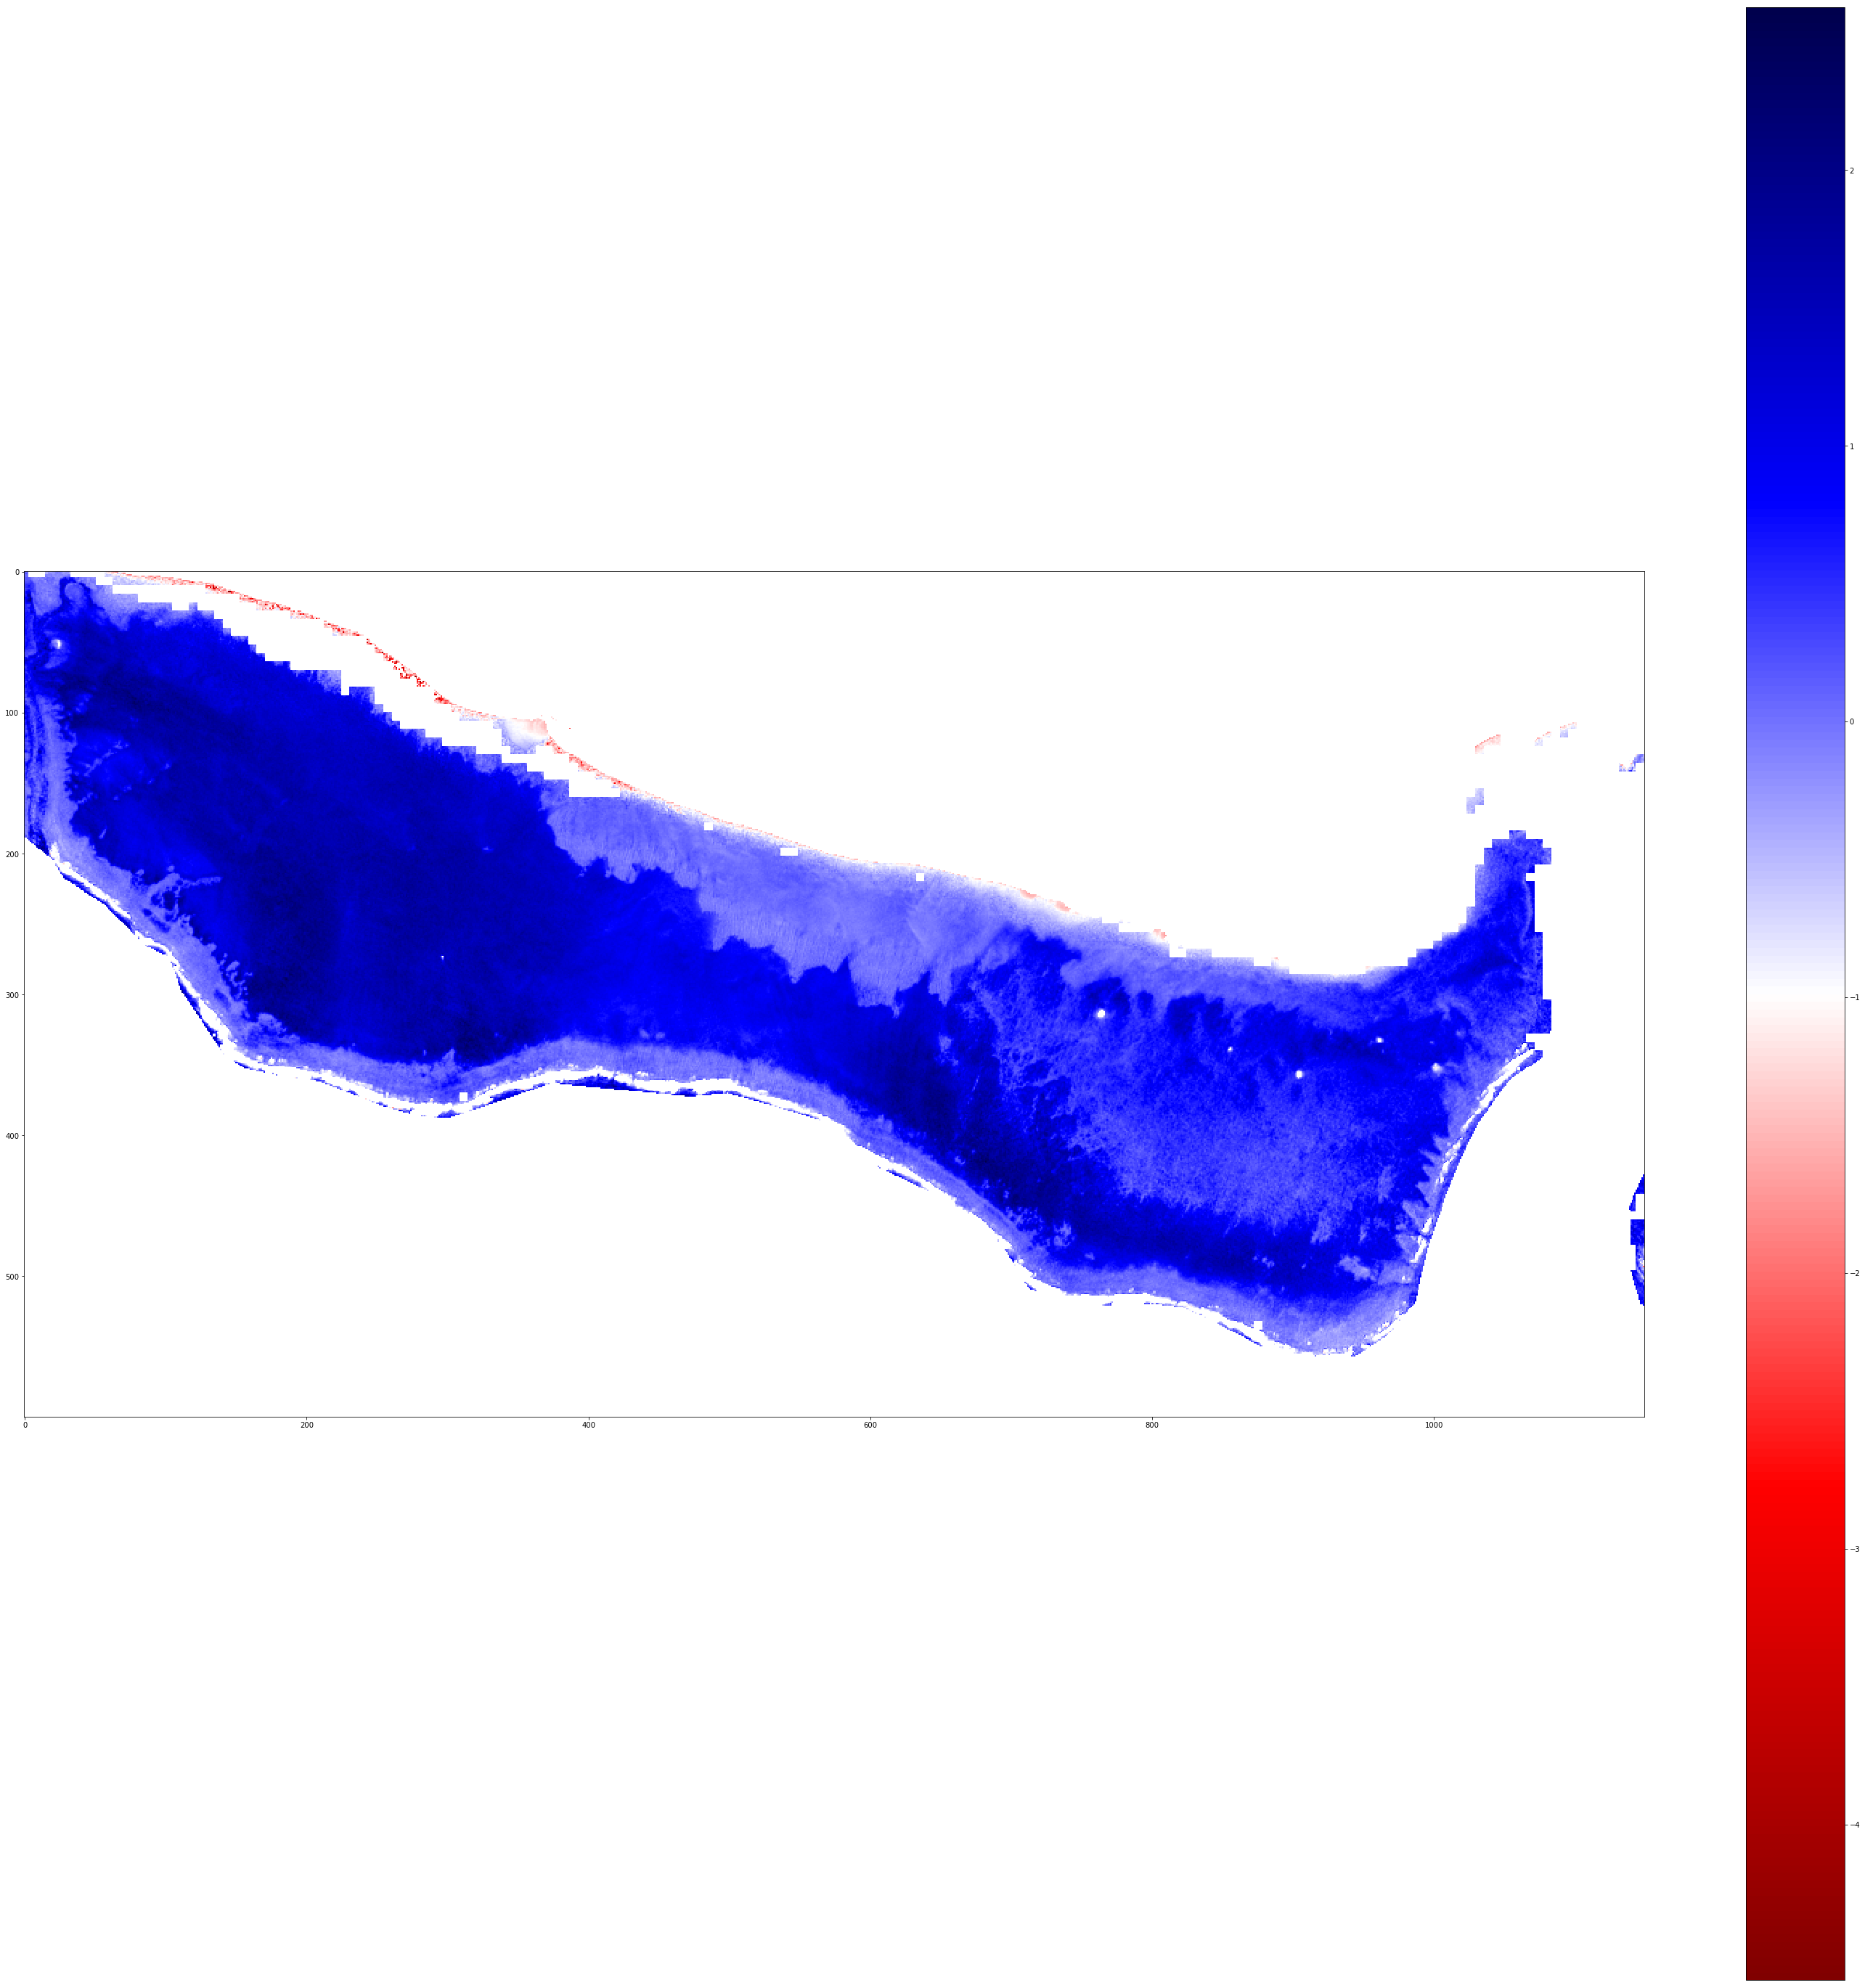

In [304]:
# Plot
fig, ax = plt.subplots(figsize=(50,50))
plt.imshow(BathyMap[8800:9400,3500:4650],cmap='seismic_r')
plt.colorbar()

# Store Metadata in dictionnary and Compute interpolated deviation map

In [305]:
# Store Metadata in dictionnary
Metadata = {}
ImageName = 'S2A_MSIL1C_20180305T230901'
Metadata['ImageName'] = 'S2A_MSIL1C_20180305T230901'

if type(modelUsed.coef_[0])==np.ndarray:  
    MatrixCoef = np.asarray(modelUsed.coef_)
    MatrixInterc = np.asarray(modelUsed.intercept_)
    Metadata['Model_coefficients'] = str({str(BandName[c]):'{0:.16f}, {1:.16f}, {2:.16f}'.format(MatrixCoef[0,c], MatrixCoef[1,c], MatrixCoef[2,c])for c in range(MatrixCoef.shape[1])})
    Metadata['Model_intercepts'] = '{0:.16f}, {1:.16f}, {2:.16f}'.format(MatrixInterc[0], MatrixInterc[1], MatrixInterc[2])
else:
    Metadata['Model_coefficients'] = str({str(BandName[i]):'{0:.16f}'.format(a) for i, a in enumerate(modelUsed.coef_)})
    Metadata['Model_intercepts'] = '{0:.16f}'.format(modelUsed.intercept_)

for a in Outputs[-1][1].keys(): 
    if not (a=='Intercept' or a=='Coefs'):
        Metadata[a] = str(Outputs[-1][1][a])

# Compute interpolated deviation map
InterpDevMethode = "nearest"
Ecart = modelUsed.predict(x) - y
DeviationMap = mgp.GetInnerInterp(Ecart, ind, methode = InterpDevMethode)
Metadata['Description'] = 'Band1: Depth prediction at zero hydrographic level, Band2: Interpolated deviation map (prediction - true) with '+InterpDevMethode+' method' 
Metadata['Description de la Zone de Calibration'] = Roidescription[CalibZoIndex]

BathyRaster = np.stack((BathyMap,DeviationMap), axis=2)
BathyRaster.shape
del BathyMap, DeviationMap

In [306]:

os.listdir('../../Resultats/Bathymetries/'+ImageName)

['Lyzenga_NoClass_2ItersLasso_PixInterp_linear_CoverPixRatio18%_CalibZone_SheratonLagoonWithPass.tif',
 'Lyzenga_NoClass_2ItersLinearRegression_PixInterp_linear_CoverPixRatio18%_CalibZone_SheratonLagoonWithPass.tif',
 'Lyzenga_NoClass_2ItersRidge_PixInterp_linear_CoverPixRatio18%_CalibZone_SheratonLagoonWithPass.tif',
 'Lyzenga_NoClass_Lasso_PixInterp_linear_CoverPixRatio18%_CalibZone_SheratonLagoonWithPass.tif',
 'Lyzenga_NoClass_LinearRegression_PixInterp_linear_CoverPixRatio18%_CalibZone_SheratonLagoon.tif',
 'Lyzenga_NoClass_LinearRegression_PixInterp_linear_CoverPixRatio18%_CalibZone_SheratonLagoonWithPass.tif',
 'Lyzenga_NoClass_Ridge_PixInterp_linear_CoverPixRatio18%_CalibZone_SheratonLagoon.tif',
 'Lyzenga_NoClass_Ridge_PixInterp_linear_CoverPixRatio18%_CalibZone_SheratonLagoonWithPass.tif',
 'Old',
 'Stumpf_NoClass_2Iters_LinearRegression_PixInterp_linear_CoverPixRatio18%_CalibZone_SheratonLagoonWithPass.tif',
 'Stumpf_NoClass_2Iters_LinearRegression_PixInterp_linear_CoverPixR

# Write Geotiff raster

In [307]:
BathyFolder = '../../Resultats/Bathymetries/S2A_MSIL1C_20180305T230901/'
TempoFolder = '/vsimem/'
filename = 'Lyzenga_NoClass_' + str(modelUsed).split("(")[0] + \
            "_PixInterp_" + PixMethod[PixMethodIndex] + \
            "_CoverPixRatio" + '{0:.0f}%_'.format(CoverThreshold*100)+ \
            'CalibZone_'+ RoiPathName[CalibZoIndex][:-4]+ \
            ".tif"
fTempName = TempoFolder + filename
fname = BathyFolder + filename

mgp.write_raster2(fTempName, BathyRaster, GT_ds, proj, DriverName="GTiff", formatMem=gdal.GDT_Float32,Metadata=Metadata, Offset=None)
response = gdal.Translate(destName=fname, srcDS=fTempName, srcWin=(0, 5500, 8500, 5480))
if response is None:
    print('fail')

In [308]:
modelUsed

Lasso(alpha=9.9999999999999995e-07, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)